In [19]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn import metrics

from keras.models import Sequential
from keras.layers import Dense, Dropout, regularizers
from keras.layers import LSTM


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import backend as K
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence


import warnings
import numpy as np
from collections import OrderedDict

import os

from lob_data_utils import lob, db_result, gdf_pca, model
from lob_data_utils.svm_calculation import lob_svm


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
data_length = 24000
stock = '2748'
gdf_filename_pattern = 'gdf_{}_r{}_s{}_K50'
gdf_parameters = [(0.1, 0.1), (0.01, 0.1), (0.1, 0.5), (0.01, 0.5), (0.25, 0.25)]

In [6]:
gdf_dfs = []
for r, s in gdf_parameters:
    gdf_dfs.append(gdf_pca.SvmGdfResults(
        stock,  r=r, s=s, data_length=data_length, data_dir='../../data/data_gdf', 
        reg_data_dir='../../data/prepared',
        gdf_filename_pattern=gdf_filename_pattern))

In [7]:
df = gdf_dfs[2].df
df_test = gdf_dfs[2].df_test
n_components = gdf_dfs[2].get_pca('pca_n_gdf_que_prev').n_components_
class_weights = gdf_dfs[2].get_classes_weights()
print(n_components, class_weights)

5 {0.0: 0.5838756766620036, 1.0: 3.4806018854242207}


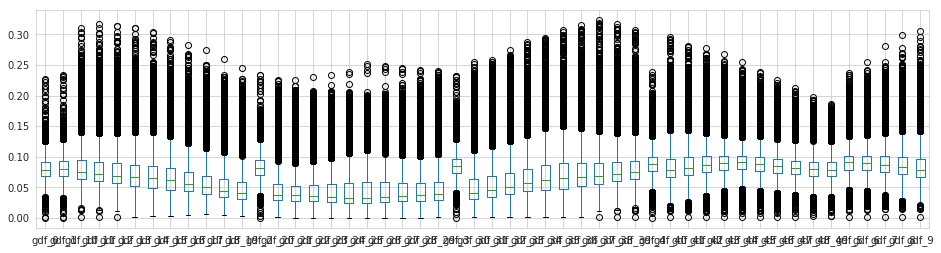

In [8]:
df[[c for c in df.columns if 'gdf' in c]].boxplot(figsize=(16, 4))

In [20]:
def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper
import tensorflow as tf
auc_roc = as_keras_metric(tf.metrics.auc)

def matthews_correlation(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

In [21]:
## With validation

In [25]:
def get_model():
    model = Sequential()
    model.add(LSTM(32, input_shape=(16, 8)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc_roc])
    return model

In [38]:
epochs = 50
batch_size = 256
score, m = gdf_dfs[0].train_lstm(
    get_model, feature_name='pca_n_gdf_que', plot_name='here.png', n_steps=16,
    fit_kwargs={'epochs': epochs, 'batch_size': batch_size, 'verbose': 1, 'shuffle': False}, 
    class_weight=class_weights,
    compile_kwargs= { 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'metrics': 
                     [matthews_correlation, auc_roc]}, should_return_model=True)

Train on 8720 samples, validate on 3488 samples
Epoch 1/50
8720/8720 [==============================] - 9s 1ms/step - loss: 0.6938 - matthews_correlation: 0.0763 - auc: 0.5034 - val_loss: 0.6943 - val_matthews_correlation: 0.0959 - val_auc: 0.5472
Epoch 2/50
8720/8720 [==============================] - 2s 221us/step - loss: 0.6870 - matthews_correlation: 0.1011 - auc: 0.5938 - val_loss: 0.6817 - val_matthews_correlation: 0.1014 - val_auc: 0.6064
Epoch 3/50
8720/8720 [==============================] - 2s 231us/step - loss: 0.6788 - matthews_correlation: 0.0789 - auc: 0.6234 - val_loss: 0.6399 - val_matthews_correlation: 0.0518 - val_auc: 0.6227
Epoch 4/50
8720/8720 [==============================] - 2s 235us/step - loss: 0.6656 - matthews_correlation: 0.0565 - auc: 0.6304 - val_loss: 0.5910 - val_matthews_correlation: 0.0312 - val_auc: 0.6266
Epoch 5/50
8720/8720 [==============================] - 2s 257us/step - loss: 0.6486 - matthews_correlation: 0.0493 - auc: 0.6359 - val_loss: 0.60

8720/8720 [==============================] - 3s 292us/step - loss: 0.6323 - matthews_correlation: 0.0809 - auc: 0.6575 - val_loss: 0.5375 - val_matthews_correlation: 0.0666 - val_auc: 0.6618
Epoch 10/50
8720/8720 [==============================] - 3s 379us/step - loss: 0.6310 - matthews_correlation: 0.0868 - auc: 0.6611 - val_loss: 0.5356 - val_matthews_correlation: 0.0630 - val_auc: 0.6648
Epoch 11/50
8720/8720 [==============================] - 3s 380us/step - loss: 0.6296 - matthews_correlation: 0.0952 - auc: 0.6643 - val_loss: 0.5332 - val_matthews_correlation: 0.0585 - val_auc: 0.6676
Epoch 12/50
8720/8720 [==============================] - 3s 301us/step - loss: 0.6283 - matthews_correlation: 0.0933 - auc: 0.6672 - val_loss: 0.5307 - val_matthews_correlation: 0.0804 - val_auc: 0.6702
Epoch 13/50
8720/8720 [==============================] - 2s 191us/step - loss: 0.6269 - matthews_correlation: 0.0911 - auc: 0.6699 - val_loss: 0.5278 - val_matthews_correlation: 0.0859 - val_auc: 0.67

8720/8720 [==============================] - 3s 293us/step - loss: 0.6290 - matthews_correlation: 0.0971 - auc: 0.6738 - val_loss: 0.5579 - val_matthews_correlation: 0.1053 - val_auc: 0.6751
Epoch 21/50
8720/8720 [==============================] - 3s 293us/step - loss: 0.6276 - matthews_correlation: 0.1042 - auc: 0.6755 - val_loss: 0.5566 - val_matthews_correlation: 0.1132 - val_auc: 0.6769
Epoch 22/50
8720/8720 [==============================] - 2s 248us/step - loss: 0.6261 - matthews_correlation: 0.1182 - auc: 0.6773 - val_loss: 0.5544 - val_matthews_correlation: 0.1207 - val_auc: 0.6786
Epoch 23/50
8720/8720 [==============================] - 2s 209us/step - loss: 0.6245 - matthews_correlation: 0.1227 - auc: 0.6790 - val_loss: 0.5550 - val_matthews_correlation: 0.1277 - val_auc: 0.6803
Epoch 24/50
8720/8720 [==============================] - 2s 199us/step - loss: 0.6230 - matthews_correlation: 0.1382 - auc: 0.6807 - val_loss: 0.5571 - val_matthews_correlation: 0.1492 - val_auc: 0.68

Epoch 48/50
19184/19184 [==============================] - 4s 213us/step - loss: 0.6047 - auc: 0.7144 - val_loss: 0.5269 - val_auc: 0.7145
Epoch 49/50
19184/19184 [==============================] - 4s 194us/step - loss: 0.6044 - auc: 0.7147 - val_loss: 0.5270 - val_auc: 0.7148
Epoch 50/50
19184/19184 [==============================] - 4s 210us/step - loss: 0.6039 - auc: 0.7150 - val_loss: 0.5272 - val_auc: 0.7152
Epoch 1/50
19184/19184 [==============================] - 12s 606us/step - loss: 0.6873 - matthews_correlation: 0.0685 - auc: 0.5298
Epoch 2/50
19184/19184 [==============================] - 4s 192us/step - loss: 0.6673 - matthews_correlation: 0.0589 - auc: 0.6170
Epoch 3/50
19184/19184 [==============================] - 3s 169us/step - loss: 0.6415 - matthews_correlation: 0.0587 - auc: 0.6378
Epoch 4/50
19184/19184 [==============================] - 4s 222us/step - loss: 0.6395 - matthews_correlation: 0.0587 - auc: 0.6516
Epoch 5/50
19184/19184 [==============================

In [39]:
score['matthews'], score['test_matthews'], score['roc_auc'], score['test_roc_auc']

(0.1864440496186898,
 0.14204215955085736,
 0.6131614719196711,
 0.5937282755270409)

In [ ]:
a = plt.plot(m.get_weights()[5])

In [5]:
df_log = pd.read_csv('../../gdf_pca/res_log_que.csv')   
df_log = df_log[df_log['stock'] == int(stock)]
columns = [c for c in df_log.columns if 'matthews' in c or 'roc_auc' in c]
df_log[columns]

,matthews,roc_auc,test_matthews,test_roc_auc,train_matthews,train_roc_auc,train_val_matthews,train_val_roc_auc
22,0.143627,0.592444,0.13427,0.596587,0.105855,0.575097,0.101212,0.569234
